## 1. Data preparation

### Load the dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score,accuracy_score,roc_curve,roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from tqdm.auto import tqdm
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
data = './diabetes_dataset.csv'

In [8]:
!head $data

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


In [9]:
df = pd.read_csv(data)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Exploratory Data Analysis (EDA)

### Display basic information about the dataset

In [10]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [12]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Check for missing values

In [13]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [14]:
target_label = 'Outcome'

In [15]:
numeric_columns = df._get_numeric_data()
object_columns = df.select_dtypes(include=['object'])
X = numeric_columns.drop(target_label,axis = 1)
y = df[[target_label]]
y.columns,X.columns

(Index(['Outcome'], dtype='object'),
 Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age'],
       dtype='object'))

In [16]:
features = X.columns.to_list()
features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### Plot distributions for numerical columns

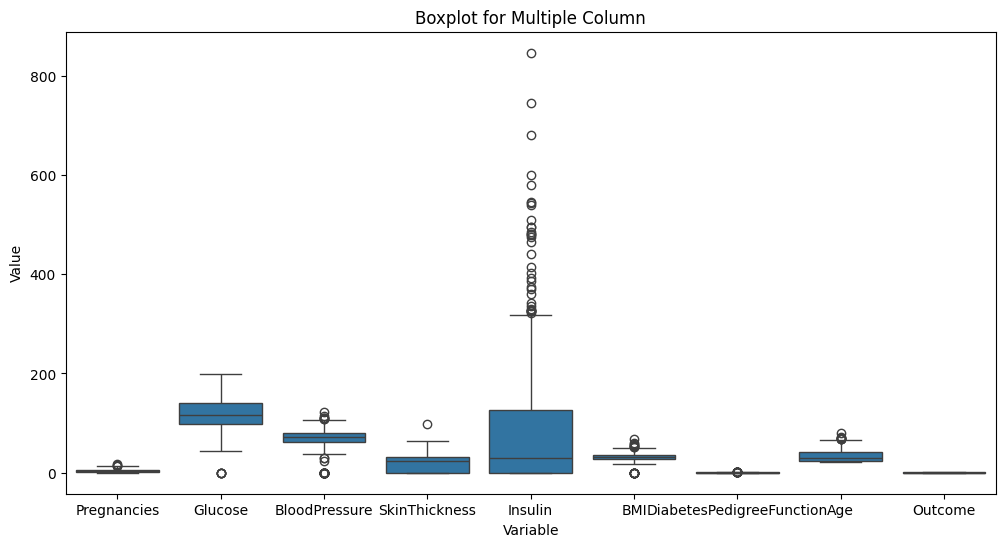

In [17]:
def showBoxplt(df):
    df_melted = df.melt(var_name='Variable', value_name='Value')
    # Create a boxplot with custom color
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Variable', y='Value', data=df_melted)  # Set2 is an example palette
    plt.title('Boxplot for Multiple Column')
    plt.show()
showBoxplt(df)

### Remove Outliers

In [18]:
def remove_outliers_iqr(df,column):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Filtering out the rows that are outside of the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Remove outliers
df = remove_outliers_iqr(df,'Glucose')
df = remove_outliers_iqr(df,'BloodPressure')
df = remove_outliers_iqr(df,'SkinThickness')
df = remove_outliers_iqr(df,'Insulin')
df = remove_outliers_iqr(df,'BMI')
df = remove_outliers_iqr(df,'Age')

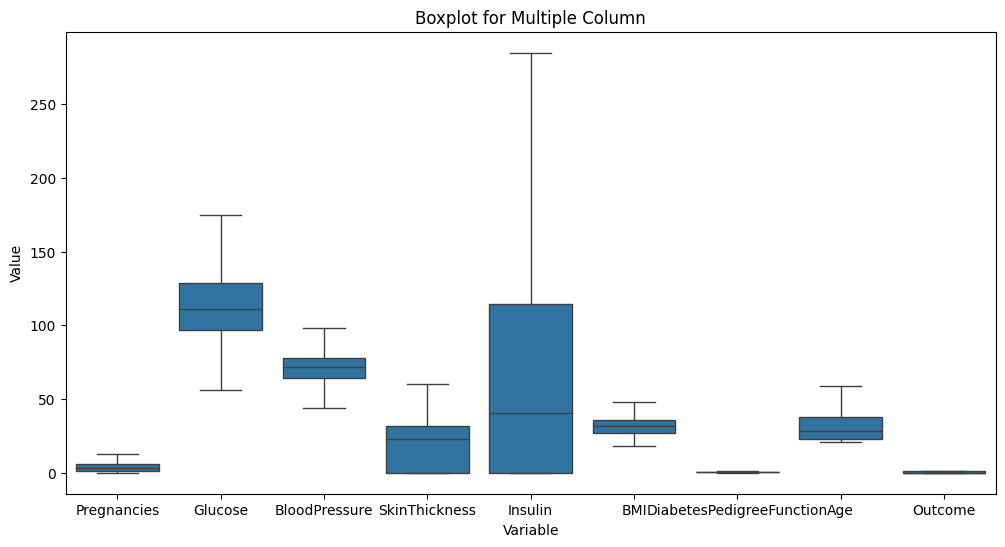

In [19]:
showBoxplt(df)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               556 non-null    int64  
 1   Glucose                   556 non-null    int64  
 2   BloodPressure             556 non-null    int64  
 3   SkinThickness             556 non-null    int64  
 4   Insulin                   556 non-null    int64  
 5   BMI                       556 non-null    float64
 6   DiabetesPedigreeFunction  556 non-null    float64
 7   Age                       556 non-null    int64  
 8   Outcome                   556 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 43.4 KB


In [21]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,3.687050,114.052158,71.206835,20.492806,62.794964,31.617086,0.410581,31.167266,0.267986
std,3.220863,24.316438,10.645069,15.212310,73.911520,6.274195,0.226119,9.639020,0.443309
min,0.000000,56.000000,44.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,97.000000,64.000000,0.000000,0.000000,26.975000,0.237000,23.000000,0.000000
50%,3.000000,111.000000,72.000000,23.000000,40.500000,31.600000,0.349000,28.000000,0.000000
75%,6.000000,129.000000,78.000000,32.000000,114.250000,35.625000,0.557500,38.000000,1.000000
max,13.000000,175.000000,98.000000,60.000000,285.000000,48.300000,1.022000,59.000000,1.000000


In [22]:
class_counts = df[target_label].value_counts()
class_ratio = class_counts.min() / class_counts.max()
print("Class imbalance ratio:", class_ratio)
#If the ratio is much lower than 1, it indicates an imbalance.

Class imbalance ratio: 0.36609336609336607


### Correlation heatmap

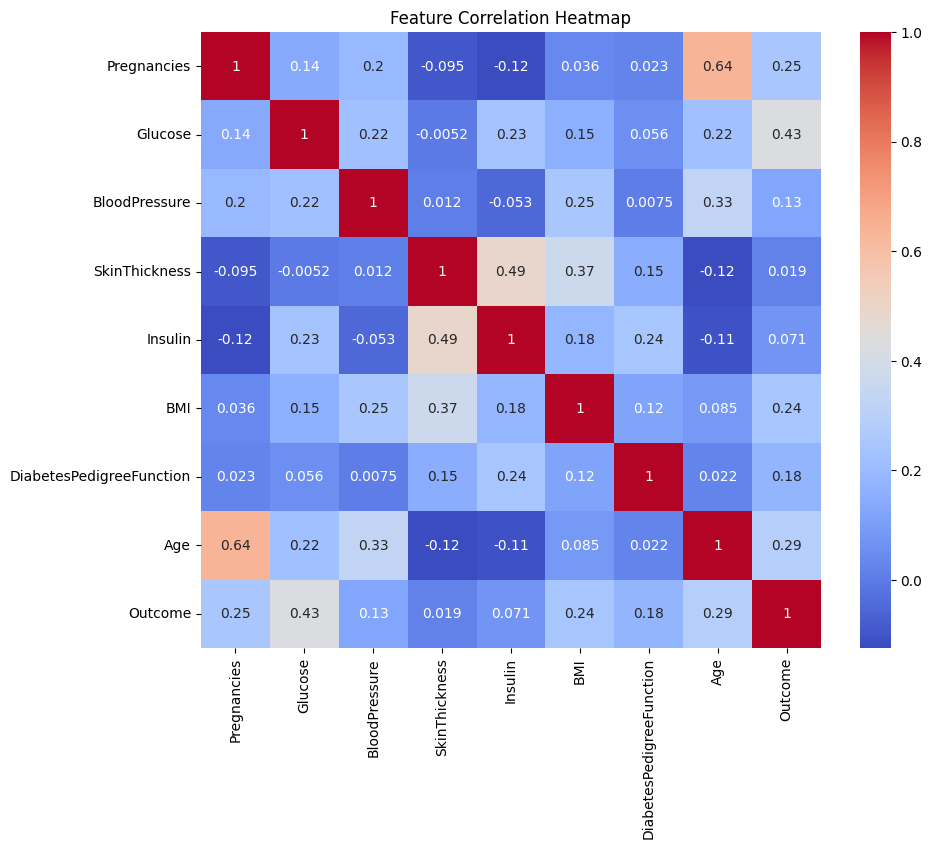

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [24]:
df.corr().unstack().sort_values(ascending=False).iloc[8:]

,,0
Outcome,Outcome,1.000000
Pregnancies,Age,0.639163
Age,Pregnancies,0.639163
Insulin,SkinThickness,0.486622
SkinThickness,Insulin,0.486622
...,...,...
Insulin,Age,-0.106722
Age,SkinThickness,-0.123725
SkinThickness,Age,-0.123725
Pregnancies,Insulin,-0.124026


In [25]:
df_target = df[target_label]
total = df_target.count()
df_target.value_counts()/total

,count
Outcome,
0,0.732014
1,0.267986


### Feature Engineering

In [26]:
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, np.inf],
                              labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Encode BMI_Category
data = pd.get_dummies(df, columns=['BMI_Category'], drop_first=True)

# Display the modified dataset
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category_Normal,BMI_Category_Overweight,BMI_Category_Obese
0,6,148,72,35,0,33.6,0.627,50,1,False,False,True
1,1,85,66,29,0,26.6,0.351,31,0,False,True,False
3,1,89,66,23,94,28.1,0.167,21,0,False,True,False
5,5,116,74,0,0,25.6,0.201,30,0,False,True,False
6,3,78,50,32,88,31.0,0.248,26,1,False,False,True


### Split dataset to train and test

In [27]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'BMI_Category_Normal', 'BMI_Category_Overweight', 'BMI_Category_Obese'],
      dtype='object')

In [28]:
categorical = [
    'BMI_Category_Normal', 'BMI_Category_Overweight', 'BMI_Category_Obese'
]

In [29]:
numerical = data.columns.drop(categorical)
numerical = numerical.to_list()
numerical.remove('BMI')
numerical.remove(target_label)
numerical

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'DiabetesPedigreeFunction',
 'Age']

In [30]:
data[categorical].head()

,BMI_Category_Normal,BMI_Category_Overweight,BMI_Category_Obese
0,False,False,True
1,False,True,False
3,False,True,False
5,False,True,False
6,False,False,True


In [31]:
global_obese = data.Outcome.mean()
global_obese

0.26798561151079137

In [32]:
def mutual_info_obese_score(series):
    return mutual_info_score(series, data.Outcome)

In [33]:
mi = data[categorical].apply(mutual_info_obese_score)
mi.sort_values(ascending=False)

,0
BMI_Category_Obese,0.028933
BMI_Category_Normal,0.028669
BMI_Category_Overweight,0.003492


In [34]:
data[numerical].corrwith(data.Outcome).abs()

,0
Pregnancies,0.248129
Glucose,0.429107
BloodPressure,0.125304
SkinThickness,0.018855
Insulin,0.070583
DiabetesPedigreeFunction,0.175675
Age,0.289717


In [142]:
def generate_data(data):
    df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
    df_train = df_full_train[categorical+numerical]
    df_val = df_test[categorical+numerical]
    y_train = df_full_train[target_label].values
    y_val = df_test[target_label].values
    del df_full_train[target_label]
    del df_test[target_label]
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train.fillna(0).to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    val_dicts = df_val.fillna(0).to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    return df_train, df_val, y_train, y_val, dv, X_train, X_val

In [158]:
def classification_evaluation_report(y_test, y_pred, title, best_params, t = 0.5):
  print(f"{title} Classification Report: {best_params}")
  print(classification_report(y_test, y_pred >= t))  # Adjust threshold as needed
  # Calculate each metric individually
  precision = precision_score(y_test, y_pred >= t)
  recall = recall_score(y_test, y_pred >= t)
  f1 = f1_score(y_test, y_pred >= t)
  auc_roc = roc_auc_score(y_test, y_pred)

  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")
  print(f"AUC-ROC Score: {auc_roc}")

In [112]:
random_state = 42
def evaluation_model(title, model, param_grid,cv=5,scoring= 'f1'):# Use 'f1' for imbalanced classes or 'roc_auc' for overall performance,# cv=5: 5-fold cross-validation

    # Configure GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring= scoring,
        verbose=1,
        n_jobs=-1  # Use all available cores
    )
    # Fit the model with GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best estimator
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best Hyperparameters:", best_params)

    # Step 5: Evaluate the best model
    y_pred = best_model.predict(X_val)
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]

    print(f"{title} Classification Report:\n", classification_report(y_val, y_pred))
    print("AUC-ROC Score:", roc_auc_score(y_val, y_pred_proba))
    return (best_params,best_model)

## 3. Model selection process and parameter tuning

### 3.1 LogisticRegression

In [143]:
df_train, df_val, y_train, y_val, dv, X_train, X_val = generate_data(data)

In [113]:
# Define the model
model_lr = LogisticRegression(solver='liblinear', random_state=random_state)

# Set up the hyperparameter grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Penalty type (L1 or L2 regularization)
    'class_weight': ['balanced', None]
}
best_params_lr, best_model_lr = evaluation_model("LogisticRegression", model_lr, param_grid_lr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84        83
           1       0.56      0.83      0.67        29

    accuracy                           0.79       112
   macro avg       0.74      0.80      0.75       112
weighted avg       0.83      0.79      0.80       112

AUC-ROC Score: 0.8695471541337765


In [114]:
best_params_lr, best_model_lr

({'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'},
 LogisticRegression(C=10, class_weight='balanced', penalty='l1', random_state=42,
                    solver='liblinear'))

In [149]:
def plot_accuracy_score(y_val, y_pred):
    thresholds = np.linspace(0, 1, 21)
    scores = []
    for t in thresholds:
        score = accuracy_score(y_val, y_pred >= t)
        # print('%.2f %.3f' % (t, score))
        scores.append(score)
    plt.plot(thresholds, scores)

def plot_roc_curve(y_val, y_pred):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='Model')
    plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

def show_plots(model):
    y_pred = model.predict_proba(X_val)[:, 1]
    plot_accuracy_score(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)
    return y_pred

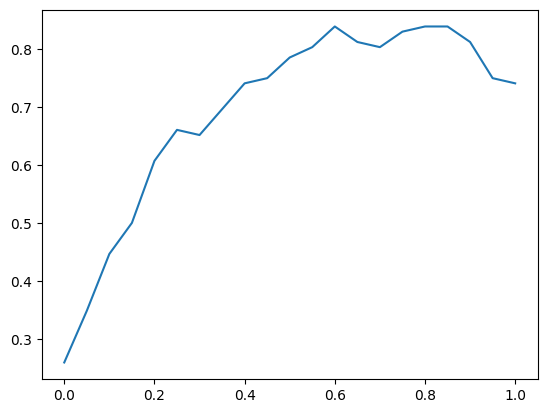

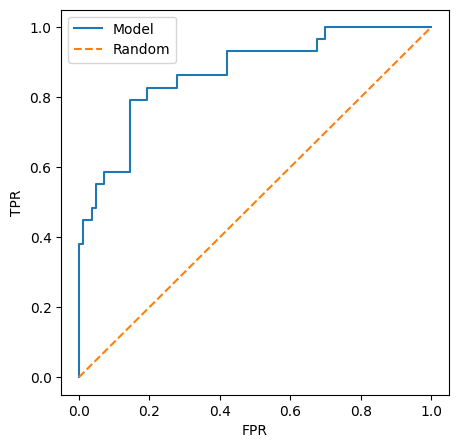

In [150]:
best_model_lr.fit(X_train, y_train)
y_pred_lr = show_plots(best_model_lr)

In [124]:
best_params_lr, best_model_lr

({'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'},
 LogisticRegression(C=10, class_weight='balanced', penalty='l1', random_state=42,
                    solver='liblinear'))

### LogisticRegressionClassifier Report

In [159]:
classification_evaluation_report(y_val,y_pred_lr,"LogisticRegression",best_params_lr)

LogisticRegression Classification Report: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        83
           1       0.56      0.83      0.67        29

    accuracy                           0.79       112
   macro avg       0.74      0.80      0.75       112
weighted avg       0.83      0.79      0.80       112

Precision: 0.5581395348837209
Recall: 0.8275862068965517
F1 Score: 0.6666666666666666
AUC-ROC Score: 0.8695471541337765


### Save the model

In [125]:
def save_logistic_regression_model(dv, model, c):
    output_file = f'lr_model_C={c}.bin'
    return save_model(dv, model, output_file)
def save_model(dv, model, output_file):
    f_out = open(output_file, 'wb')
    pickle.dump((dv, model), f_out)
    f_out.close()
    return output_file

In [126]:
C = 10
input_file = save_logistic_regression_model(dv, best_model_lr, C)

In [127]:
!ls -lh *.bin

-rw-r--r-- 1 root root 1.2K Nov 12 14:48 'lr_model_C=10.bin'


### Load the model and test

In [128]:
input_file

'lr_model_C=10.bin'

In [129]:
def load_model(input_file):
    with open(input_file, 'rb') as f_in:
        dv, model = pickle.load(f_in)
    return dv, model

In [130]:
dv, model = load_model(input_file)
model

LogisticRegression(C=10, class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

In [131]:
def predict_single(patient, dv, model):
    X = dv.transform([patient])
    y_pred = model.predict_proba(X)[0, 1]
    print('input:', patient)
    print('output:', y_pred)
    return y_pred

In [132]:
p = data.iloc[0]

p1 = {"Pregnancies":1,"Glucose":85,"BloodPressure":66,"SkinThickness":29,"Insulin":0,"DiabetesPedigreeFunction":0.351,"Age":31,
      "BMI_Category_Normal":'false',
      "BMI_Category_Overweight":'true',
      "BMI_Category_Obese":'false'}
p2 = {"Pregnancies":6,"Glucose":148,"BloodPressure":72,"SkinThickness":35,"Insulin":0,"DiabetesPedigreeFunction":0.627,"Age":50,
      "BMI_Category_Normal":'false',
      "BMI_Category_Overweight":'false',
      "BMI_Category_Obese":'true'}
p.to_json()

'{"Pregnancies":6,"Glucose":148,"BloodPressure":72,"SkinThickness":35,"Insulin":0,"BMI":33.6,"DiabetesPedigreeFunction":0.627,"Age":50,"Outcome":1,"BMI_Category_Normal":false,"BMI_Category_Overweight":false,"BMI_Category_Obese":true}'

In [133]:
predict_single(p1, dv, model)

input: {'Pregnancies': 1, 'Glucose': 85, 'BloodPressure': 66, 'SkinThickness': 29, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.351, 'Age': 31, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'true', 'BMI_Category_Obese': 'false'}
output: 0.07495747043225456


0.07495747043225456

In [134]:
predict_single(p2, dv, model)

input: {'Pregnancies': 6, 'Glucose': 148, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.627, 'Age': 50, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'false', 'BMI_Category_Obese': 'true'}
output: 0.8933551340522232


0.8933551340522232

### 3.2 DecisionTreeClassifier

In [153]:
df_train, df_val, y_train, y_val, dv, X_train, X_val = generate_data(data)

In [167]:
# Define the model
model_dt = DecisionTreeClassifier(random_state=random_state)

# Set up the hyperparameter grid
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8,10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}
best_params_dt, best_model_dt = evaluation_model("DecisionTree", model_dt, param_grid_dt)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
DecisionTree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79        83
           1       0.43      0.52      0.47        29

    accuracy                           0.70       112
   macro avg       0.62      0.64      0.63       112
weighted avg       0.72      0.70      0.70       112

AUC-ROC Score: 0.6609887827170753


In [154]:
best_params_dt, best_model_dt

({'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 2},
 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=4, random_state=42))

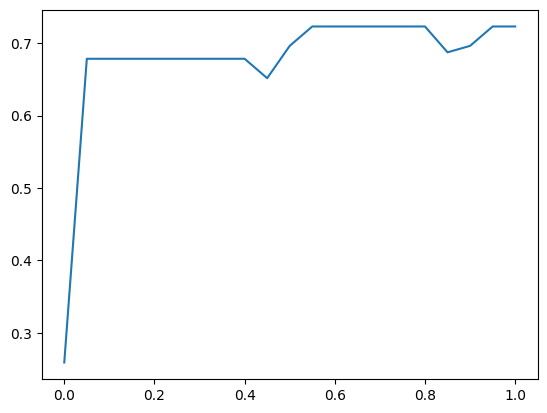

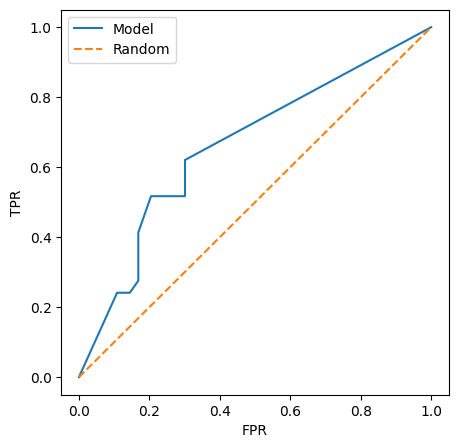

In [155]:
best_model_dt.fit(X_train, y_train)
y_pred_dt = show_plots(best_model_dt)

In [156]:
print(export_text(best_model_dt, feature_names=list(dv.get_feature_names_out())))

|--- Glucose <= 101.50
|   |--- Age <= 42.50
|   |   |--- DiabetesPedigreeFunction <= 0.67
|   |   |   |--- SkinThickness <= 40.50
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.16
|   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.15
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- DiabetesPedigreeFunction >  0.15
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.16
|   |   |   |   |   |--- BMI_Category_Obese <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- BMI_Category_Obese >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- SkinThickness >  40.50
|   |   |   |   |--- class: 0
|   |   |--- DiabetesPedigreeFunction >  0.67
|   |   |   |--- Insulin <= 89.00
|   |   |   |   |--- class: 0
|   |   |   |--- Insulin >  89.00
|   |   |   |   |--- class: 1
|   |--- Age >  42.50
|   |   |--- SkinThickness <= 31.50
|   |   |   |--- DiabetesPedigreeFunction <= 0.38
|   |   |   |   |--- class: 1
|   |  

###  DecisionTreeClassifier Report

In [160]:
classification_evaluation_report(y_val,y_pred_dt,"DecisionTreeClassifier",best_params_dt)

DecisionTreeClassifier Classification Report: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        83
           1       0.43      0.52      0.47        29

    accuracy                           0.70       112
   macro avg       0.62      0.64      0.63       112
weighted avg       0.72      0.70      0.70       112

Precision: 0.42857142857142855
Recall: 0.5172413793103449
F1 Score: 0.46875
AUC-ROC Score: 0.6609887827170753


In [161]:
def save_decisionTreeClassifier_model(dv, dt, max_depth=4,min_samples_leaf=10,min_samples_split=2):
    output_file = f'dtc_model_max_depth={max_depth}_min_samples_leaf={min_samples_leaf}_min_samples_split={min_samples_split}.bin'
    return save_model(dv, dt, output_file)

### Save the model

In [162]:
input_file = save_decisionTreeClassifier_model(dv,best_model_dt)
input_file

'dtc_model_max_depth=4_min_samples_leaf=10_min_samples_split=2.bin'

### Load the model and test

In [163]:
dv, dt = load_model(input_file)
dt

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, random_state=42)

In [164]:
predict_single(p1,dv, dt)

input: {'Pregnancies': 1, 'Glucose': 85, 'BloodPressure': 66, 'SkinThickness': 29, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.351, 'Age': 31, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'true', 'BMI_Category_Obese': 'false'}
output: 0.0


0.0

In [165]:
predict_single(p2,dv, dt)

input: {'Pregnancies': 6, 'Glucose': 148, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.627, 'Age': 50, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'false', 'BMI_Category_Obese': 'true'}
output: 0.0


0.0

### 3.3 RandomForestClassifier

In [166]:
df_train, df_val, y_train, y_val, dv, X_train, X_val = generate_data(data)

In [168]:
# Define the model
model_rf = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}
best_params_rf, best_model_rf = evaluation_model("RandomForest", model_rf, param_grid_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.85        83
           1       0.58      0.76      0.66        29

    accuracy                           0.79       112
   macro avg       0.74      0.78      0.76       112
weighted avg       0.82      0.79      0.80       112

AUC-ROC Score: 0.8537598670544246


In [169]:
best_params_rf, best_model_rf

({'class_weight': 'balanced',
  'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 100},
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=4, min_samples_split=10,
                        random_state=42))

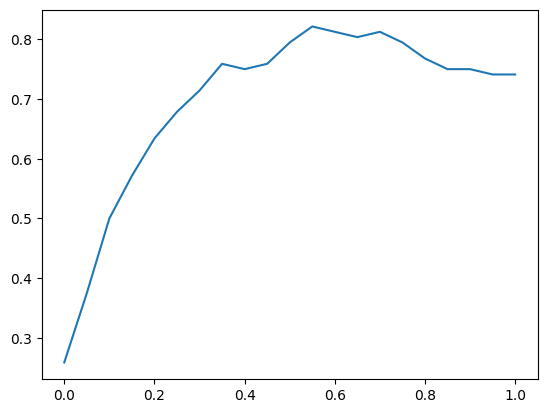

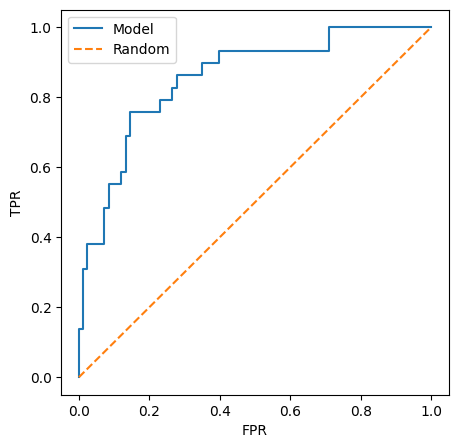

In [170]:
best_model_rf.fit(X_train, y_train)
y_pred_rf = show_plots(best_model_rf)

### RandomForestClassifier Report

In [176]:
classification_evaluation_report(y_val,y_pred_rf,"RandomForestClassifier",best_params_rf)

RandomForestClassifier Classification Report: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.91      0.81      0.85        83
           1       0.58      0.76      0.66        29

    accuracy                           0.79       112
   macro avg       0.74      0.78      0.76       112
weighted avg       0.82      0.79      0.80       112

Precision: 0.5789473684210527
Recall: 0.7586206896551724
F1 Score: 0.6567164179104478
AUC-ROC Score: 0.8537598670544246


### Save the model

In [171]:
def save_RandomForestClassifier(dv, rf, n_estimators=100,max_depth=10,min_samples_leaf=4,min_samples_split=10):
    output_file = f'rfc_model_n_estimators={max_depth}_max_depth={max_depth}_min_samples_leaf={min_samples_leaf}_min_samples_split={min_samples_split}.bin'
    return save_model(dv, rf, output_file)

In [172]:
input_file = save_RandomForestClassifier(dv, best_model_rf)
input_file

'rfc_model_n_estimators=10_max_depth=10_min_samples_leaf=4_min_samples_split=10.bin'

### Load the model and test

In [178]:
dv, rf = load_model(input_file)
rf

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [179]:
predict_single(p1,dv, rf)

input: {'Pregnancies': 1, 'Glucose': 85, 'BloodPressure': 66, 'SkinThickness': 29, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.351, 'Age': 31, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'true', 'BMI_Category_Obese': 'false'}
output: 0.12920818062711273


0.12920818062711273

In [182]:
predict_single(p2,dv, rf)

input: {'Pregnancies': 6, 'Glucose': 148, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.627, 'Age': 50, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'false', 'BMI_Category_Obese': 'true'}
output: 0.6735313000745006


0.6735313000745006

### 3.4 Selecting the final model: LogisticRegression Classification {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}